# Prueba 1
**Nombre:** Julio Valdés
<br>
**Generación:** GC

### Configuración y lectura de datos

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("prueba-1")\
    .enableHiveSupport()\
    .getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
26,application_1579965305852_0027,pyspark3,idle,,,✔


SparkSession available as 'spark'.


In [2]:
spark

In [3]:
data = spark.read.parquet('s3://bigdata-desafio/transantiago')
data.show(5)

+-------------------+-------------+-------------+-----------+-----------+--------------------+--------+--------+--------+
|       fechahoratrx|codigoentidad|nombreentidad|codigositio|nombresitio|          nrotarjeta|     day|    from|      to|
+-------------------+-------------+-------------+-----------+-----------+--------------------+--------+--------+--------+
|2018-08-08 06:17:00|            4| U4 - Express|       5517|    ZN-6156|10699ec735e3a7ef1...|20180903|20180827|20180829|
|2018-08-08 06:17:03|            4| U4 - Express|       5517|    ZN-6156|43ce6a265f01a62f1...|20180903|20180827|20180829|
|2018-08-08 06:17:40|            4| U4 - Express|       5517|    ZN-6156|b5476ff3fd038b53d...|20180903|20180827|20180829|
|2018-08-08 06:17:44|            4| U4 - Express|       5517|    ZN-6156|c79b63a8c7112ea5f...|20180903|20180827|20180829|
|2018-08-08 06:17:47|            4| U4 - Express|       5517|    ZN-6156|d2c27d8ff4b0f0701...|20180903|20180827|20180829|
+-------------------+---

In [4]:
transactions = data.select('fechahoratrx', 'codigoentidad', 'nombreentidad', 'codigositio', 'nombresitio', 'nrotarjeta')
transactions.show(5)

+-------------------+-------------+-------------+-----------+-----------+--------------------+
|       fechahoratrx|codigoentidad|nombreentidad|codigositio|nombresitio|          nrotarjeta|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
|2018-08-08 06:17:00|            4| U4 - Express|       5517|    ZN-6156|10699ec735e3a7ef1...|
|2018-08-08 06:17:03|            4| U4 - Express|       5517|    ZN-6156|43ce6a265f01a62f1...|
|2018-08-08 06:17:40|            4| U4 - Express|       5517|    ZN-6156|b5476ff3fd038b53d...|
|2018-08-08 06:17:44|            4| U4 - Express|       5517|    ZN-6156|c79b63a8c7112ea5f...|
|2018-08-08 06:17:47|            4| U4 - Express|       5517|    ZN-6156|d2c27d8ff4b0f0701...|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
only showing top 5 rows

In [5]:
transactions.registerTempTable('transactions')

### Ejercicio 1: Operaciones básicas (1 punto)

Determine:
<li>Cantidad de transacciones.</li>
<li>Primera y última transacción en función de la columna fechahoratrx</li>

In [6]:
print("La cantidad de transacciones son {}".format(transactions.count()))

La cantidad de transacciones son 456532128

In [7]:
print("La primera transaccion en función de la columna fechahoratrx es")
transactions\
            .orderBy('fechahoratrx', ascending=True)\
            .show(1)

La primera transaccion en función de la columna fechahoratrx es
+-------------------+-------------+-------------+-----------+-----------+--------------------+
|       fechahoratrx|codigoentidad|nombreentidad|codigositio|nombresitio|          nrotarjeta|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
|2018-04-16 19:04:59|            2|  U2 - Su Bus|      14008|    BJFD-95|5a00a171594e87599...|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
only showing top 1 row

In [8]:
print("La última transaccion en función de la columna fechahoratrx es")
transactions\
            .orderBy('fechahoratrx', ascending=False)\
            .show(1)

La última transaccion en función de la columna fechahoratrx es
+-------------------+-------------+-------------+-----------+-----------+--------------------+
|       fechahoratrx|codigoentidad|nombreentidad|codigositio|nombresitio|          nrotarjeta|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
|2018-09-03 22:55:22|           15| U1 - Alsacia|      13942|    BJFD-13|12dbec71fb4d0dde9...|
+-------------------+-------------+-------------+-----------+-----------+--------------------+
only showing top 1 row

### Ejercicio 2: Operadores del servicio (1 punto)

<li>Liste los distintos operadores.</li>
<li>Muestre la cantidad de transacciones para cada operador.</li>

In [9]:
print("Distintos operadores")
transactions\
            .select('nombreentidad')\
            .distinct()\
            .orderBy('nombreentidad', ascending=True)\
            .show()

Distintos operadores
+------------------+
|     nombreentidad|
+------------------+
|        METRO - OT|
|      Tren Central|
|      U1 - Alsacia|
|       U2 - Su Bus|
|         U3 - Vule|
|      U4 - Express|
|U5 - Metropolitana|
|       U6 - Redbus|
|          U7 - STP|
+------------------+

In [10]:
print("Cantidad de transacciones por operador")
transactions\
            .groupBy('nombreentidad')\
            .count()\
            .orderBy('count', ascending=False)\
            .show()

Cantidad de transacciones por operador
+------------------+---------+
|     nombreentidad|    count|
+------------------+---------+
|        METRO - OT|202471859|
|         U3 - Vule| 48198386|
|U5 - Metropolitana| 46727071|
|      U4 - Express| 42893078|
|       U2 - Su Bus| 39337668|
|      U1 - Alsacia| 27317884|
|       U6 - Redbus| 26101394|
|          U7 - STP| 17825212|
|      Tren Central|  5659576|
+------------------+---------+

### Ejercicio 3: Tarjetas Bip! (4 puntos)

#### Muestre las 20 tarjetas con más transacciones. (2 puntos)

In [11]:
top20_transactions_by_card = spark.sql( """
    SELECT nrotarjeta, count(nrotarjeta) FROM transactions
    GROUP BY nrotarjeta
    ORDER BY count(nrotarjeta) DESC
    LIMIT 20
""")
print("Las 20 tarjetas con más transacciones")
top20_transactions_by_card.show()

Las 20 tarjetas con más transacciones
+--------------------+-----------------+
|          nrotarjeta|count(nrotarjeta)|
+--------------------+-----------------+
|deec3122b409a5fc5...|             1411|
|de9c88570da017d4a...|             1263|
|3067b87bcbd4539f6...|             1194|
|469ea593723b604d5...|             1163|
|803c9ddf9d09d177f...|             1153|
|fa3875d0e0cc7ccd5...|             1153|
|9eeec446133e409fa...|             1142|
|96d6b2eb577ab2629...|             1139|
|b34fa35f11aa675f1...|             1139|
|06cfe644a7b163bec...|             1131|
|7ca23ee541b387e96...|             1125|
|3ed8575b3d1d5281f...|             1118|
|a5c1d005449309320...|             1109|
|1760b3b06c2d4d718...|             1108|
|8d09ad5982ef800f7...|             1102|
|15af9115719b3e3c4...|             1086|
|46313191acb7ab2ec...|             1082|
|773f1ec9877777b91...|             1067|
|64eb75d0b2396ab30...|             1064|
|94f04c2250766d9ff...|             1061|
+------------------

#### Cuente todas las tarjetas que posean más de 2 transacciones por día. (2 puntos)
**Supuesto:** Se consideran las tarjetas que han tenido más de 2 transacciones en al menos un día y no todos los días.

In [12]:
cards_with_two_or_more_transactions_by_day = spark.sql( """
    SELECT count(distinct(nrotarjeta)) FROM 
        (SELECT to_date(fechahoratrx) as fecha, nrotarjeta, count(nrotarjeta)
        FROM transactions
        GROUP BY fecha, nrotarjeta
        HAVING count(nrotarjeta) > 2)
""")
print("Cantidad de tarjetas que poseen más de 2 transacciones por día:")
cards_with_two_or_more_transactions_by_day.show()

Cantidad de tarjetas que poseen más de 2 transacciones por día:
+--------------------------+
|count(DISTINCT nrotarjeta)|
+--------------------------+
|                   5353814|
+--------------------------+

### Ejercicio 4: Fechas y rangos de horario (4 puntos)

#### Determine los 10 días con más transacciones. (1 punto)

In [13]:
top10_days_with_more_transactions = spark.sql( """
    SELECT to_date(fechahoratrx) as fecha, count(nrotarjeta) FROM transactions
    GROUP BY fecha
    ORDER BY count(nrotarjeta) DESC
    LIMIT 10
""")
top10_days_with_more_transactions.show()

+----------+-----------------+
|     fecha|count(nrotarjeta)|
+----------+-----------------+
|2018-08-24|         35500762|
|2018-08-28|         34907307|
|2018-08-27|         34875930|
|2018-08-29|         31530669|
|2018-08-23|         30946604|
|2018-08-22|         26971860|
|2018-08-30|         25727297|
|2018-08-16|         23844751|
|2018-08-21|         23675505|
|2018-08-20|         23649525|
+----------+-----------------+

#### Realice una comparación de la cantidad de transacciones por hora para cada operador. Muestre sus resultados en un gráfico donde el eje X sea la hora del día y el eje Y la cantidad de transacciones. (3 puntos)

In [14]:
%%spark -o transactions_by_hour_and_operator
transactions_by_hour_and_operator = spark.sql( """
    SELECT extract(hour from fechahoratrx) as hora, nombreentidad as operador, count(fechahoratrx) as cantidad
    FROM transactions
    GROUP BY hora, operador
    ORDER BY hora ASC
""")
transactions_by_hour_and_operator.show(5)

+----+------------------+--------+
|hora|          operador|cantidad|
+----+------------------+--------+
|   0|U5 - Metropolitana|  139816|
|   0|       U2 - Su Bus|  103308|
|   0|         U3 - Vule|   91194|
|   0|          U7 - STP|   28135|
|   0|      U4 - Express|  156822|
+----+------------------+--------+
only showing top 5 rows

Text(0, 0.5, 'Cantidad de transacciones')

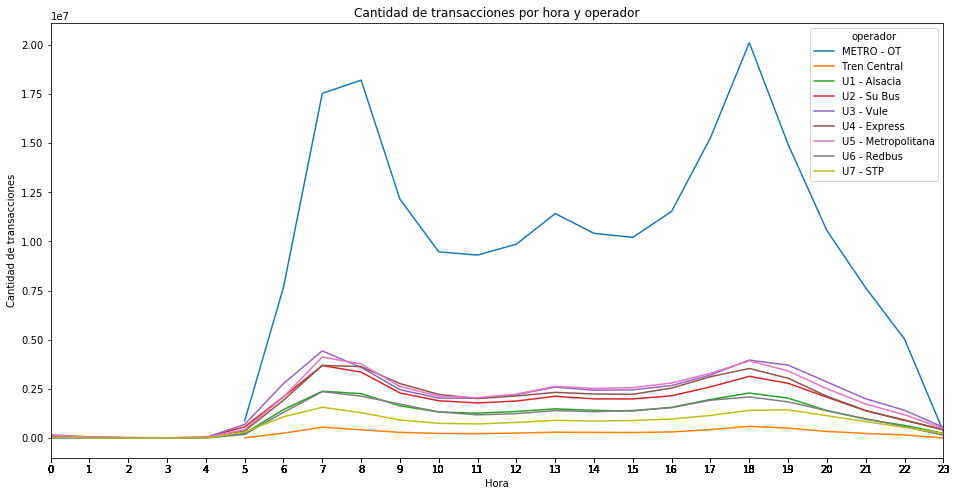

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,8))
transactions_by_hour_and_operator.groupby(['hora', 'operador']).sum()['cantidad'].unstack().plot(ax=ax)
plt.xticks(transactions_by_hour_and_operator.hora);
plt.title('Cantidad de transacciones por hora y operador')
plt.xlabel('Hora')
plt.ylabel('Cantidad de transacciones')


#### Comentarios
En el gráfico se puede observar lo siguiente:
* Existe una gran diferencia entre la cantidad de transacciones que se realizan en el METRO versus las que se realizan en el sistema de buses y trenes.
* El sistema de transporte público tiene dos horarios altos en cuanto a las transacciones, entre 06:30 y 09:30 AM y luego entre 17:00 y 19:00 horas aproximadamente.
* El sistema de buses comienza a aumentar las transacciones aproximadamente a las 04:00 AM mientras que el METRO lo hace a partir de las 05:00 AM.
* El Tren Central se mantiene casi sin variación durante el día.
